In [120]:
import pandas as pd
import numpy as np
import json
import seaborn as sns


In [121]:
with open('primed_qtable.json', 'r') as file:
    data = json.load(file)

In [122]:
data_df = pd.DataFrame(data)
data_df

,0,1,2,3,4,5,6
0,0.730869,0.708569,0.095931,0.280404,0.454817,0.309406,0.248359
1,0.930778,0.954873,0.492477,0.500506,0.726277,0.725075,0.378110
2,0.101587,0.149501,0.778042,0.132020,0.624651,0.798704,0.450076
3,0.929667,0.009356,0.493607,0.237723,0.144024,0.252783,0.317030
4,0.392232,0.981843,0.186449,0.496747,0.728064,0.011346,0.250326
...,...,...,...,...,...,...,...
21627,0.081746,0.542628,0.951121,0.824059,0.804055,0.936700,0.289088
21628,0.796450,0.562740,0.417626,0.998388,0.932081,0.026824,0.795030
21629,0.550811,0.368065,0.789012,0.160819,0.051453,0.584951,0.527541
21630,0.157836,0.697480,0.488632,0.892682,0.365924,0.984285,0.220077


In [123]:
import pickle
HEIGHT= 25*2
WIDTH = 25*2
def load_qtable(filename="qtable.pkl"):
    with open(filename, "rb") as f:
        qtable = pickle.load(f)
    return qtable

q_table = load_qtable()

In [124]:
q_table

,0,1,2,3,4,5,6
0,0.730869,0.708569,0.095931,0.280404,0.454817,0.309406,0.248359
1,0.930778,0.954873,0.492477,0.500506,0.726277,0.725075,0.378110
2,0.101587,0.149501,0.778042,0.132020,0.624651,0.798704,0.450076
3,0.929667,0.009356,0.493607,0.237723,0.144024,0.252783,0.317030
4,0.392232,0.981843,0.186449,0.496747,0.728064,0.011346,0.250326
...,...,...,...,...,...,...,...
21627,0.081746,0.542628,0.951121,0.824059,0.804055,0.936700,0.289088
21628,0.796450,0.562740,0.417626,0.998388,0.932081,0.026824,0.795030
21629,0.550811,0.368065,0.789012,0.160819,0.051453,0.584951,0.527541
21630,0.157836,0.697480,0.488632,0.892682,0.365924,0.984285,0.220077


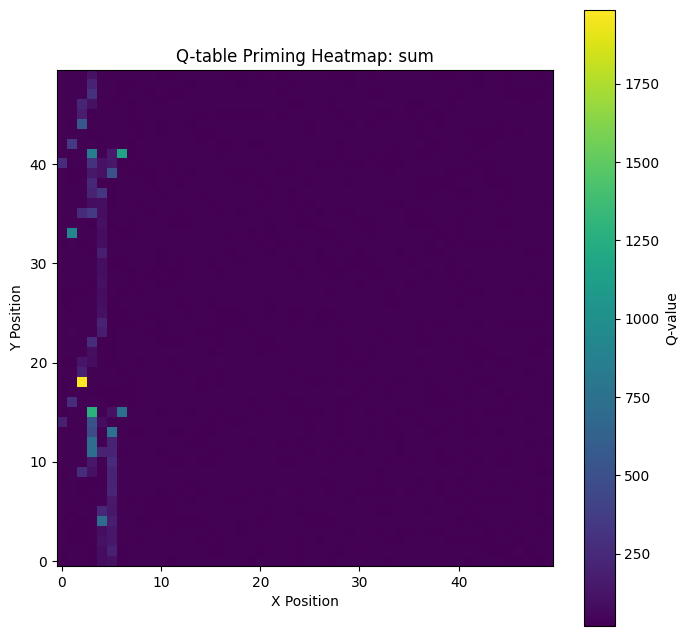

In [125]:
import numpy as np
import matplotlib.pyplot as plt

def plot_qtable_heatmap(qtable, mode="sum"):
    collapsed = np.zeros((HEIGHT, WIDTH))

    #encoding: ((((x,y)*2 + cart)*2 + items)*2 + checkout)

    for x in range(HEIGHT):
        for y in range(WIDTH):
            cell_value = 0
            for cart in [0, 1]:
                for items in [0, 1]:
                    for checkout in [0, 1]:
                        idx = ((((x*HEIGHT + y)*2 + cart)*2 + items)*2 + checkout)

                        if mode == "sum":
                            cell_value += qtable.loc[idx].sum() #sum of actions
                        elif mode == "max":
                            cell_value += qtable.loc[idx].max() #max of actions
                        else:
                            raise ValueError("mode wrong")

            collapsed[x, y] = cell_value

    plt.figure(figsize=(8, 8))
    plt.imshow(collapsed.T, origin="lower", aspect="equal")
    plt.colorbar(label="Q-value")
    plt.title(f"Q-table Priming Heatmap: {mode}")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.show()

plot_qtable_heatmap(qtable=q_table, mode="sum")


In [126]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

WIDTH = 25
HEIGHT = 25


def qtable_to_grid(qtable, width=WIDTH, height=HEIGHT):
    n_actions = qtable.shape[1]
    grid = np.zeros((width, height, n_actions))

    for x in range(width):
        for y in range(height):
            s = x * width + y
            if s < len(qtable):
                grid[x, y] = qtable[s]
    return grid



def compute_best_maps(qgrid):
    best_action = np.argmax(qgrid, axis=2)
    best_value = np.max(qgrid, axis=2)
    return best_action, best_value



def extract_subtasks(best_action, best_value, value_threshold=None):
    width, height = best_action.shape
    visited = np.zeros((width, height), dtype=bool)
    subtasks = []
    subtask_id_map = -np.ones((width, height), dtype=int)

    if value_threshold is None:
        # Automatically choose threshold = 50% of max value
        value_threshold = 0.5 * np.max(best_value)

    def neighbors(x, y):
        for dx, dy in [(1,0),(-1,0),(0,1),(0,-1)]:
            nx, ny = x+dx, y+dy
            if 0 <= nx < width and 0 <= ny < height:
                yield nx, ny

    subtask_id = 0

    for x in range(width):
        for y in range(height):
            if visited[x,y]:
                continue
            if best_value[x,y] < value_threshold:
                continue

            # start BFS for this region
            action = best_action[x,y]
            queue = deque([(x,y)])
            visited[x,y] = True

            cells = [(x,y)]

            while queue:
                cx, cy = queue.popleft()
                for nx, ny in neighbors(cx,cy):
                    if visited[nx,ny]:
                        continue
                    if best_action[nx,ny] != action:
                        continue
                    if best_value[nx,ny] < value_threshold:
                        continue

                    visited[nx,ny] = True
                    queue.append((nx,ny))
                    cells.append((nx,ny))

            # Save completed subtask
            for (cx,cy) in cells:
                subtask_id_map[cx,cy] = subtask_id

            subtasks.append({
                "id": subtask_id,
                "action": int(action),
                "cells": cells,
                "size": len(cells)
            })
            subtask_id += 1

    return subtasks, subtask_id_map


def plot_subtasks(subtask_id_map):
    plt.figure(figsize=(8,8))
    plt.imshow(subtask_id_map.T, origin="lower")
    plt.title("Subtask Regions")
    plt.colorbar(label="Subtask ID")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()


def extract_subtasks_from_qtable(qtable):
    qgrid = qtable_to_grid(qtable)
    best_action, best_value = compute_best_maps(qgrid)
    subtasks, subtask_id_map = extract_subtasks(best_action, best_value)
    return subtasks, subtask_id_map, best_action, best_value


Extracted 3 subtasks


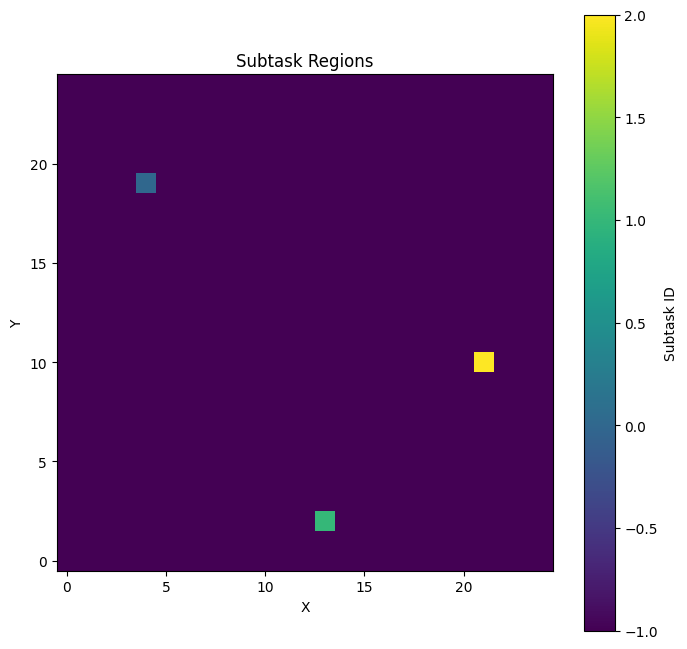

{'id': 0, 'action': 4, 'cells': [(4, 19)], 'size': 1}
{'id': 1, 'action': 4, 'cells': [(13, 2)], 'size': 1}
{'id': 2, 'action': 4, 'cells': [(21, 10)], 'size': 1}


In [127]:
# qtable = load_qtable("primed_qtable.pkl")
q_table = np.array(q_table)
subtasks, subtask_map, best_action, best_value = extract_subtasks_from_qtable(q_table)

print(f"Extracted {len(subtasks)} subtasks")

plot_subtasks(subtask_map)

for st in subtasks:
    print(st)
